# Evaluating scGPT in zero-shot setting

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import cell_embeddings, scgpt_forward, data, model_output
from sc_foundation_evals.helpers.custom_logging import log
from sc_foundation_evals.utils import eval_scib_metrics

log.setLevel(logging.INFO)

## Setting up variables

Define some variables, that we will rely on later, starting with paths and run configs.

In [3]:
# path to the pre-trained model, 3 files are expected: 
# model_weights (best_model.pt), model args (args.json), and model vocab (vocab.json)
model_dir="../../data/weights/scgpt/scGPT_human"
# batch_size depends on available GPU memory; should be a multiple of 8
batch_size=32
# output_dir is the path to which the results should be saved
output_dir="../../output/scgpt/scgpt_human/"
# path to where we will store the embeddings and other evaluation outputs
model_out = os.path.join(output_dir, "model_outputs")
# if you can use multithreading specify num_workers
num_workers=0

Now, the model configs

In [4]:
input_bins=51
model_run="pretrained"
seed=7
n_hvg=1200
# maximum sequence of the input is controlled by max_seq_len, here I'm using the pretrained default
max_seq_len=n_hvg + 1

And finally, data configs. Here, I will use the pancreas dataset to showcase the analyses. I downloaded the pancreas dataset can be accessed using the following code (as specified in the scvi-tools docs [here](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/scarches_scvi_tools.html#reference-mapping-with-scvi)). I slightly modified the batch column, as shown below. 

```python
import scanpy as sc

pancreas_adata_path = "../data/datasets/pancreas_scib.h5ad"

pancreas_adata = sc.read(
    pancreas_adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539828",
)

pancreas_adata.obs['batch'] = (
    pancreas_adata.obs["tech"]
    .str.lower()
    # merge indrop as those are all the same technology  
    .str.replace("indrop[0-9]*", "indrop", regex=True)
    )

pancreas_adata.write_h5ad(pancreas_adata_path, compression="gzip")
```

In [5]:
# specify the path to anndata object
dataset_path = "../../data/datasets/pancreas_scib.h5ad"
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"
# batch column found in adata.obs
batch_col = "batch" #"tech"
# where are labels stored in adata.obs? 
label_col = "celltype"
# where the raw counts are stored?
layer_key = "counts"
# are the values log_norm already?
log_norm = False

## Loading model and data

In [6]:
# create the model
scgpt_model = scgpt_forward.scGPT_instance(saved_model_path = model_dir,
                                           model_run = model_run,
                                           batch_size = batch_size, 
                                           save_dir = output_dir,
                                           num_workers = num_workers, 
                                           explicit_save_dir = True)

INFO     | 2024-06-05 15:52:25 | Using device cuda


In [7]:
# create config
scgpt_model.create_configs(seed = seed, 
                           max_seq_len = max_seq_len, 
                           n_bins = input_bins)

Loading the pretrained model. The log will show that some weights cannnot be loaded, as long as it is `cls_*` it's ok, as we are evaluating it in zero-shot setting, and those layers are not used.

In [8]:
scgpt_model.load_pretrained_model()

WARNING  | 2024-06-05 15:52:28 | Overriding pre-trained config['save_dir'] with ../../output/scgpt/scgpt_human/ (was /scratch/ssd004/datasets/cellxgene/save/cellxgene_census_human-May23-08-36-2023)
WARNING  | 2024-06-05 15:52:28 | Overriding pre-trained config['max_seq_len'] with 1200 (was 1200)
INFO     | 2024-06-05 15:52:28 | Loading vocab from ../../data/weights/scgpt/scGPT_human/vocab.json
INFO     | 2024-06-05 15:52:29 | Loading model from ../../data/weights/scgpt/scGPT_human/best_model.pt
WARNING  | 2024-06-05 15:52:31 | Loading partial model params from ../../data/weights/scgpt/scGPT_human/best_model.pt
WARNING  | 2024-06-05 15:52:31 | Cannot load cls_decoder._decoder.0.weight with shape torch.Size([512, 512])
WARNING  | 2024-06-05 15:52:31 | Cannot load cls_decoder._decoder.0.bias with shape torch.Size([512])
WARNING  | 2024-06-05 15:52:31 | Cannot load cls_decoder._decoder.2.weight with shape torch.Size([512])
WARNING  | 2024-06-05 15:52:31 | Cannot load cls_decoder._decoder.2

In [9]:
input_data = data.InputData(adata_dataset_path = dataset_path)

INFO     | 2024-06-05 15:52:36 | Loading data from ../../data/datasets/pancreas_scib.h5ad


To process the data we need the vocbulary. That we get from the model.

In [10]:
vocab_list = scgpt_model.vocab.get_stoi().keys()

Prepprocessing according to the steps as written in the scGPT repository. We will filter for the 1200 highly variable genes here.

In [11]:
input_data.preprocess_data(gene_vocab = vocab_list,
                           model_type = "scGPT",
                           gene_col = gene_col,
                           data_is_raw = not log_norm,
                           counts_layer = layer_key, 
                           n_bins = input_bins,
                           n_hvg = n_hvg)

WARNING  | 2024-06-05 15:52:47 | Gene names not found in var columns. Using index instead.
INFO     | 2024-06-05 15:52:47 | Matched 18160/19093 genes in vocabulary of size 60697.
INFO     | 2024-06-05 15:52:47 | Preprocessing data


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


In [12]:
scgpt_model.tokenize_data(data = input_data,
                          input_layer_key = "X_binned",
                          include_zero_genes = False)

INFO     | 2024-06-05 15:53:36 | Tokenizing data


In [13]:
input_data.adata.X.shape

(16382, 1200)

## Evaluating model outputs

First, we will perform forward pass on the model and extract embeddings.

In [14]:
scgpt_model.extract_embeddings(data = input_data)

INFO     | 2024-06-05 15:53:41 | Preparing dataloader
INFO     | 2024-06-05 15:53:41 | Saving config to ../../output/scgpt/scgpt_human/
INFO     | 2024-06-05 15:53:41 | Extracting embeddings
INFO     | 2024-06-05 15:53:41 | Extracting embeddings for batch 1/512
INFO     | 2024-06-05 15:53:47 | Extracting embeddings for batch 52/512
INFO     | 2024-06-05 15:53:52 | Extracting embeddings for batch 103/512
INFO     | 2024-06-05 15:53:58 | Extracting embeddings for batch 154/512
INFO     | 2024-06-05 15:54:03 | Extracting embeddings for batch 205/512
INFO     | 2024-06-05 15:54:08 | Extracting embeddings for batch 256/512
INFO     | 2024-06-05 15:54:14 | Extracting embeddings for batch 307/512
INFO     | 2024-06-05 15:54:19 | Extracting embeddings for batch 358/512
INFO     | 2024-06-05 15:54:25 | Extracting embeddings for batch 409/512
INFO     | 2024-06-05 15:54:30 | Extracting embeddings for batch 460/512
INFO     | 2024-06-05 15:54:35 | Extracting embeddings for batch 511/512


In [17]:
scgpt_model.cell_embeddings.shape

(16382, 512)

Next, we will specify what we want to evaluate in the output evaluations. Here, we will be using output of two pre-training objectives: masked language modelling (**MLM**), aka gene expression prediction (GEP), and **MVC** (not entirely sure what this abbreviation stands for), aka gene expression prediction from cell embedding (GEPC). 

In [13]:
#??? whether the mvc_decoder has been pretrained or not?
eval_pred = model_output.GeneExprPredEval(scgpt_model,
                                         data = input_data,
                                         output_dir = model_out,
                                         embedding_key = ["mlm_output", 
                                                          "mvc_output"])

In [14]:
eval_pred.evaluate()

WARNING  | 2023-12-05 13:20:12 | mlm_output is not a tensor


WARNING  | 2023-12-05 13:20:13 | mvc_output is not a tensor


,MSE,MSE_all,MRE,MRE_all,MAE,MAE_all
mlm_output,200.974411,200.974411,0.412700,0.412700,12.040932,12.040932
mvc_output,148.520004,148.520004,0.443404,0.445765,10.183268,10.183268
mean,202.451447,202.451447,0.487606,0.487606,12.320333,12.320333


We can also visualize the input bins and output of both of the pretraining objective.

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

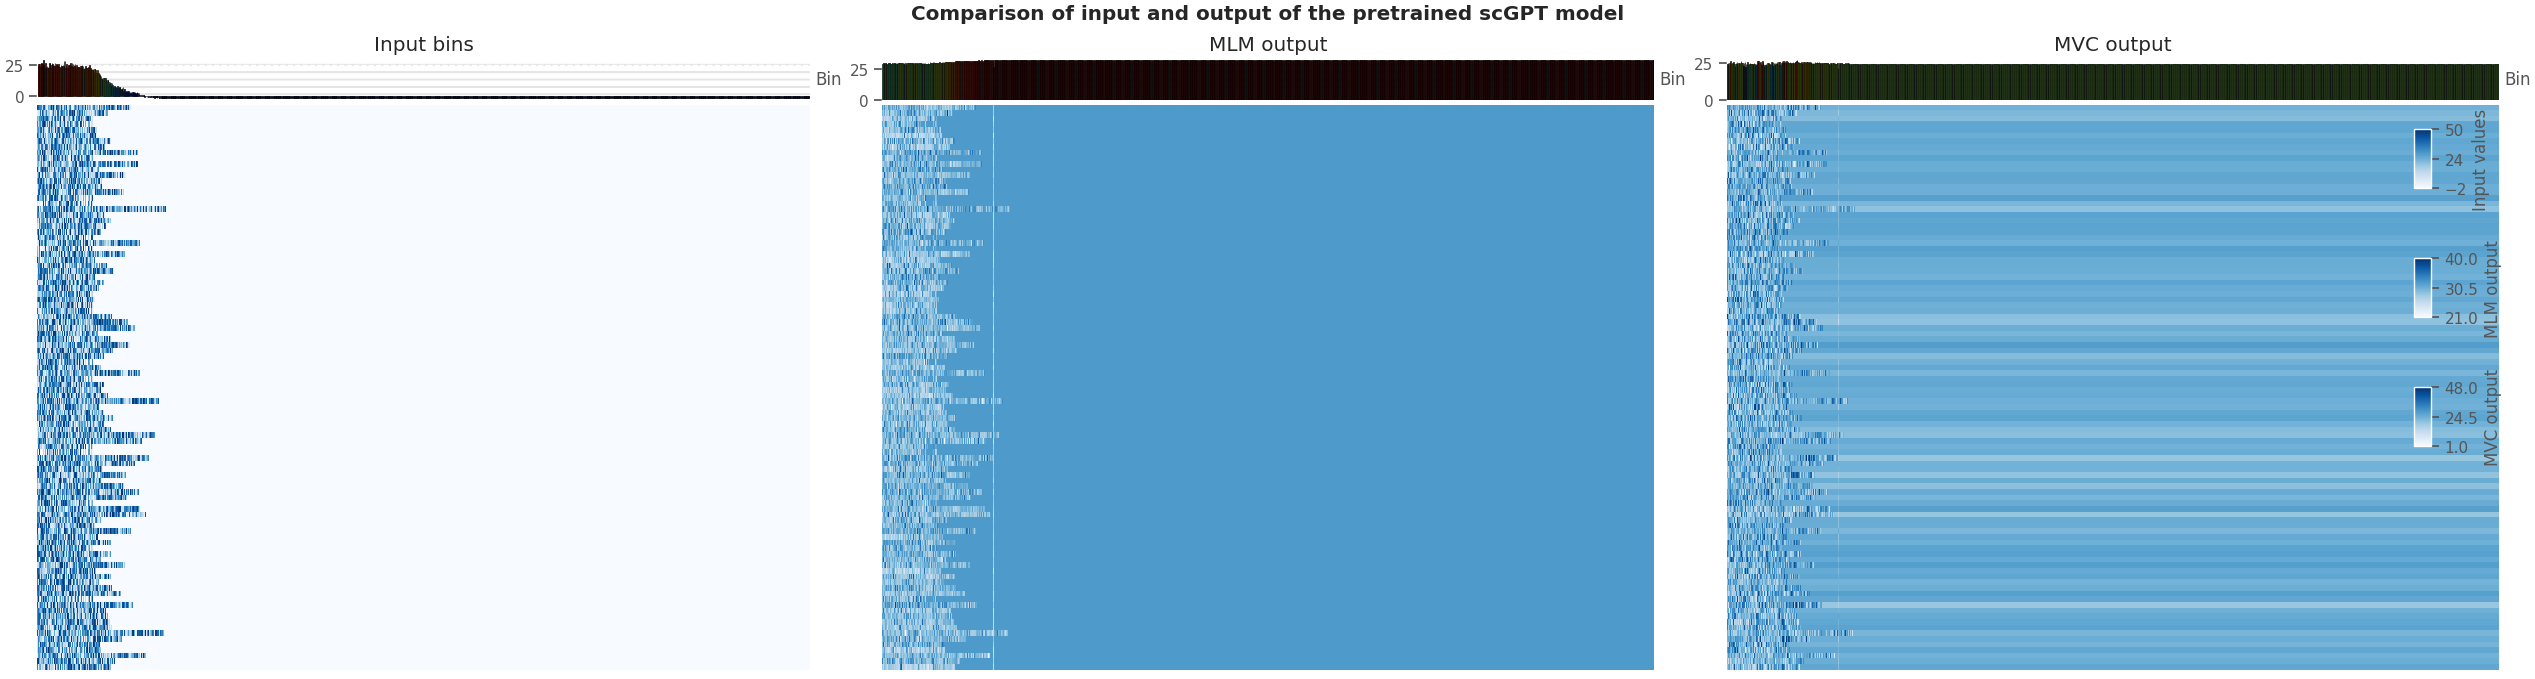

In [15]:
eval_pred.visualize(label_key = label_col)

# Evaluate the cell embeddings

In [17]:
eval_ce = cell_embeddings.CellEmbeddingsEval(scgpt_model,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)

In [17]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000)

WARNING  | 2023-12-05 13:20:39 | adata_ has 16382 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.575922
1,ARI_cluster/label,celltype,0.384832
2,ASW_label,celltype,0.527416
3,graph_conn,celltype,0.909105
4,ASW_batch,celltype,0.502584
5,ASW_label/batch,celltype,0.877185
6,PCR_batch,celltype,0.320129
7,avg_bio,celltype,0.496057


WARNING  | 2023-12-05 13:21:50 | adata_ has 16382 cells. Taking a subset of 7500 cells.
WARNING  | 2023-12-05 13:21:51 | More than 10 labels for celltype.The plots might be hard to read.


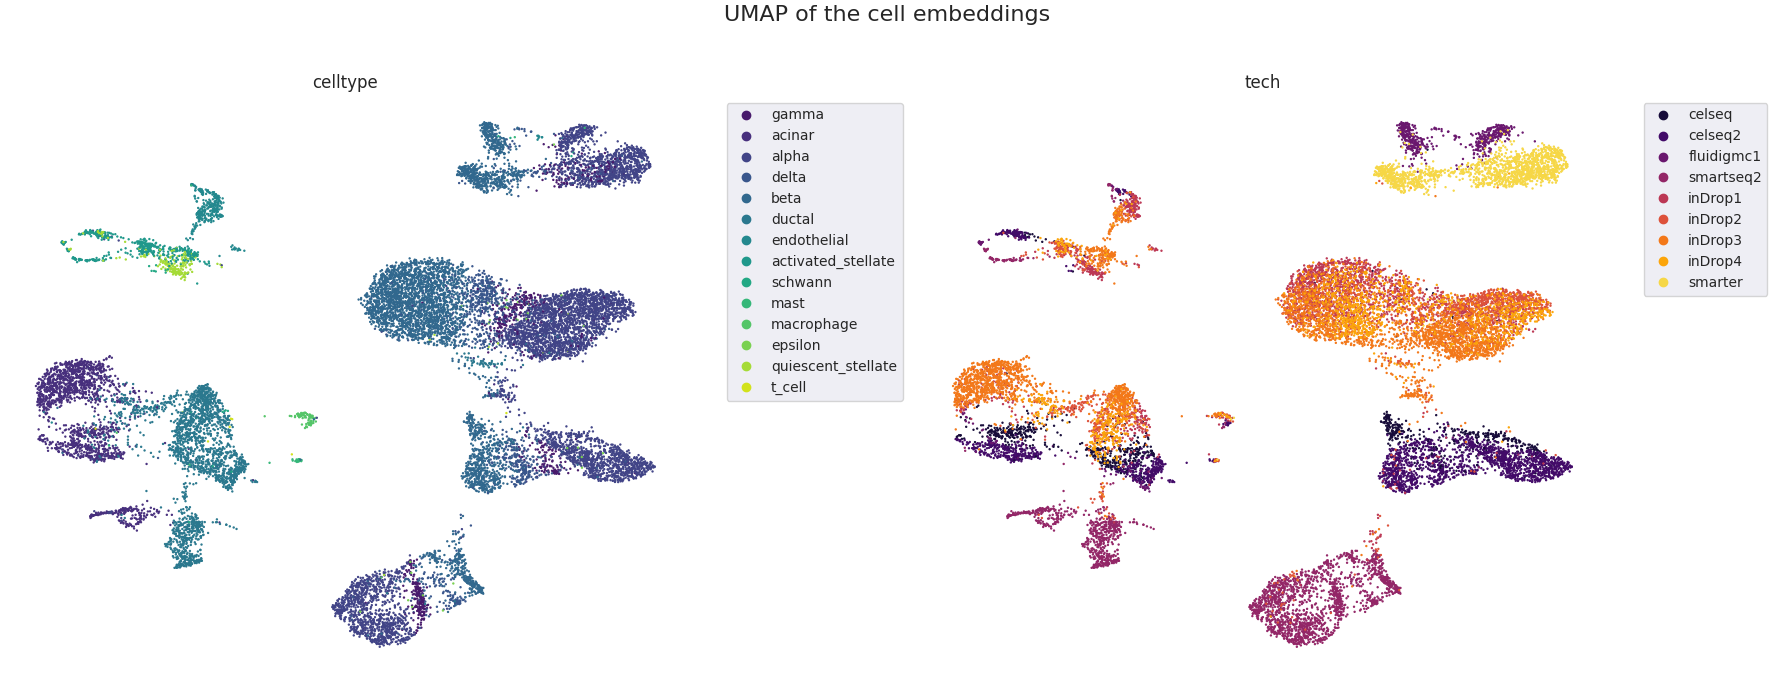

In [18]:
eval_ce.visualize()

In [16]:
use_rep_key = "X_scGPT"
adata = input_data.adata.copy()
adata.obsm[use_rep_key].shape

(16382, 512)

In [18]:
eval_scib_metrics(adata, batch_key=batch_col, label_key=label_col, embedding_key=use_rep_key)

WARNING  | 2024-06-05 16:07:12 | neighbors in adata.uns found 
 {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'X_scGPT'}} 
to make sure the optimal clustering is calculated for the correct embedding, removing neighbors from adata.uns.
Overwriting calculation of neighbors with sc.pp.neighbors(adata, use_rep=X_scGPT).
INFO     | 2024-06-05 16:07:15 | neighbors in adata.uns removed, new neighbors calculated: {'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 15, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean', 'use_rep': 'X_scGPT'}}


{'NMI_cluster/label': 0.6228893376729513,
 'ARI_cluster/label': 0.4046204332085386,
 'ASW_label': 0.5307239275425673,
 'graph_conn': 0.916065097122545,
 'ASW_batch': 0.5049833562225103,
 'ASW_label/batch': 0.8913134983257598,
 'PCR_batch': 0.31100341850954755,
 'avg_bio': 0.519411232808019}

# Reference mapping and transfer the annotations

In [18]:
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [20]:
ref_batch = ['indrop', 'celseq2', 'celseq']
adata.obs["is_ref"] = adata.obs["batch"].isin(ref_batch).astype("category")
adata.obs

,tech,celltype,size_factors,batch,n_counts,is_ref
D101_5,celseq,gamma,0.028492,celseq,6890.475586,True
D101_43,celseq,gamma,0.079348,celseq,10946.603516,True
D101_93,celseq,gamma,0.037932,celseq,7842.628418,True
D102_4,celseq,gamma,0.047685,celseq,8689.016602,True
D172444_23,celseq,gamma,0.038683,celseq,7734.086914,True
...,...,...,...,...,...,...
Sample_1594,smarter,gamma,1.000000,smarter,12430.851562,False
Sample_1595,smarter,gamma,1.000000,smarter,12046.470703,False
Sample_1597,smarter,gamma,1.000000,smarter,14035.447266,False
Sample_1598,smarter,gamma,1.000000,smarter,10483.674805,False


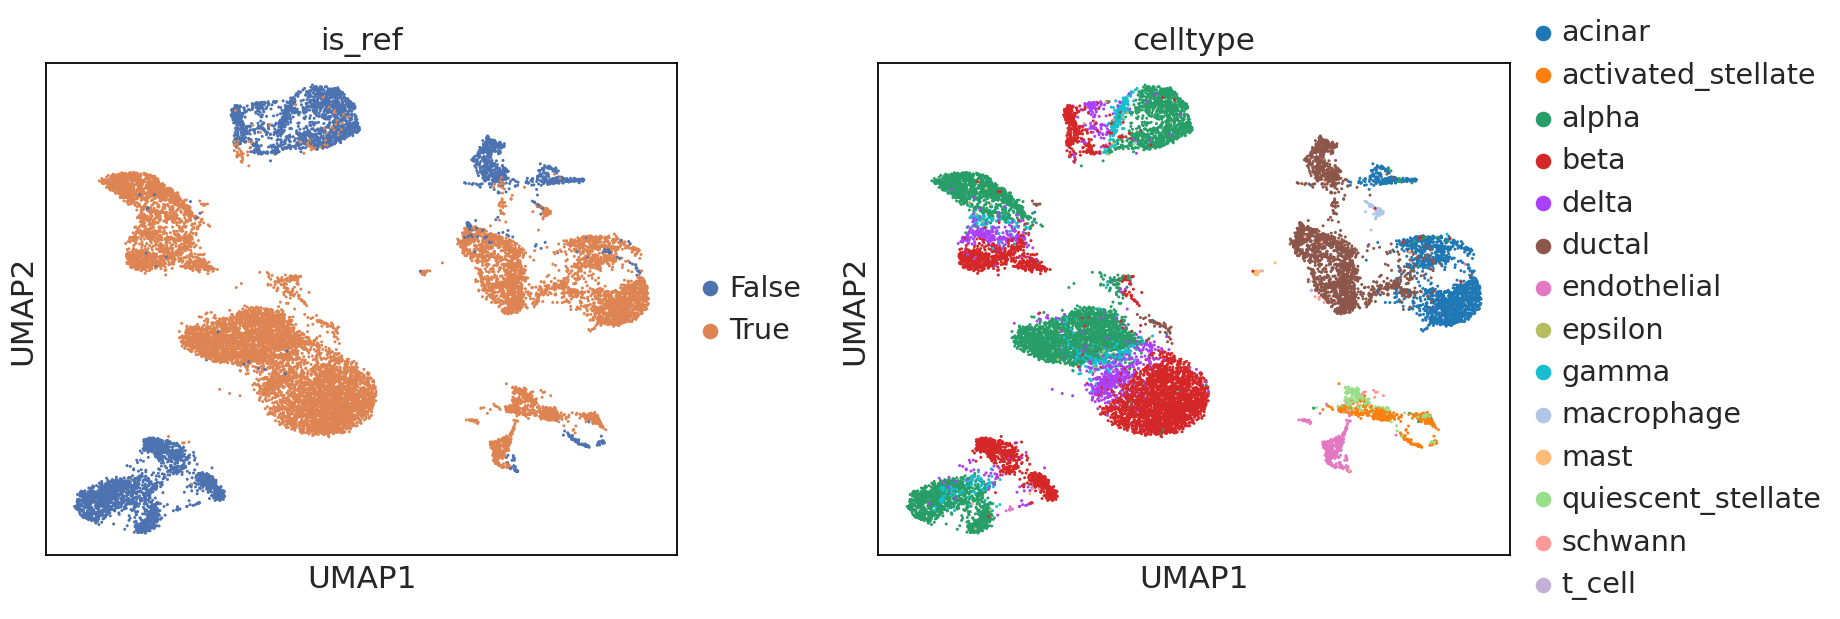

In [22]:
sc.set_figure_params(facecolor="white", figsize=(5,4), transparent=True)
sc.pp.neighbors(adata, use_rep=use_rep_key)  # use_rep: any valid key in adata.obsm
# 将距离嵌入图中
sc.tl.umap(adata, min_dist = 0.3)
fig = sc.pl.umap(adata, color=["is_ref", "celltype"], wspace=0.2, return_fig=True, frameon=True)

fig.savefig("../../output/scgpt/pancreas.png")

In [23]:
ref_adata = adata[adata.obs["is_ref"]==True]
test_adata = adata[adata.obs["is_ref"]==False]

In [24]:
ref_cell_embeddings = ref_adata.obsm[use_rep_key]
test_emebd = test_adata.obsm[use_rep_key]

k = 10  # number of neighbors

index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    idx = labels[k]
    pred = ref_adata.obs[label_col][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[label_col].to_numpy()

In [25]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.8194076038903625,
 'precision': 0.6911087600535653,
 'recall': 0.6049278217410388,
 'macro_f1': 0.6276248199244137}

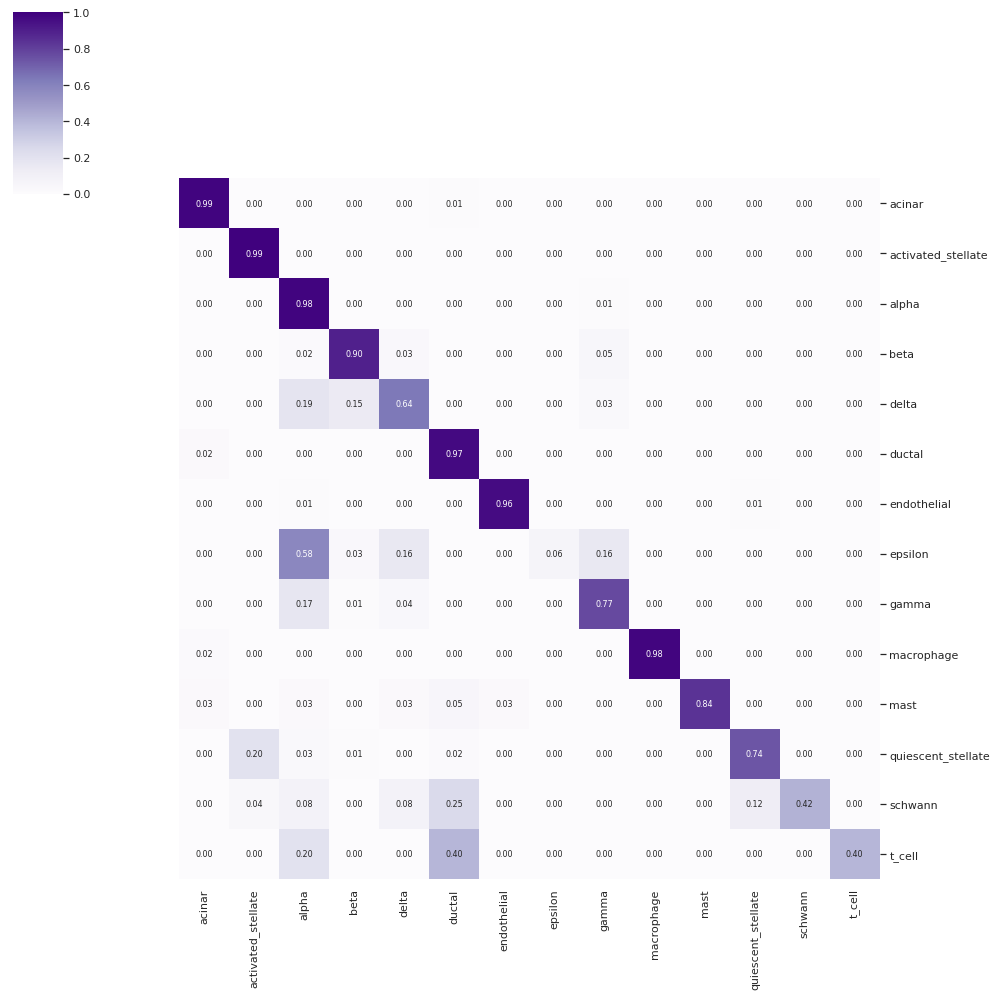

In [27]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,fmt=".2f", 
                    annot_kws={'size': 8}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14),
                    )